In [20]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from scipy.spatial import distance_matrix

from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

from rogi import RoughnessIndex

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style='ticks', font_scale=1)

In [12]:
class SurfaceConstructor:
    def __init__(self, name):
        self.name = name
    
    def __call__(self, X):
        if self.name == 'S1':
            return self.construct_S1(X)
        elif self.name == 'S2':
            return self.construct_S2(X)
        elif self.name == 'S3':
            return self.construct_S3(X)
        elif self.name == 'S4':
            return self.construct_S4(X)
        elif self.name == 'S5':
            return self.construct_S5(X)
        elif self.name == 'S6':
            return self.construct_S6(X)
        else:
            raise ValueError()
    
    @staticmethod
    def construct_S1(X):
        return X[:,0] + X[:,1]

    @staticmethod
    def construct_S2(X):
        return (X[:,0] - 0.5)**2 + (X[:,1] - 0.5)**2

    @staticmethod
    def construct_S3(X):
        # griewank fucntion
        # https://www.sfu.ca/~ssurjano/griewank.html
        X_scaled = (X * 10.) - 5.
        Y = 1. + (X_scaled[:,0]**2 + X_scaled[:,1]**2)/4000 - (np.cos(X_scaled[:,0]) * np.cos(X_scaled[:,1]) / np.sqrt(2.) )
        return Y

    @staticmethod
    def construct_S4(X):
        Y = np.array([1.] * len(X))

        d=0.1
        anchor=0.5

        mask0 = X[:,0] < anchor + d
        mask1 = X[:,0] > anchor - d
        mask2 = X[:,1] < anchor + d
        mask3 = X[:,1] > anchor - d
        mask = np.logical_and(np.logical_and(mask0, mask1), np.logical_and(mask2, mask3))
    
        Y[mask] = .0
        return Y

    @staticmethod
    def construct_S5(X):
        # chequered surface
        # d == size of squares
        d = 0.5
        Y = np.array([0.] * len(X))
        
        a0 = (X[:,0] - d/2.) % (d * 2)
        a1 = (X[:,1] + d/2.) % (d * 2)
        
        mask0 = a0 < d
        mask1 = a1 > d
        mask = np.logical_and(mask0, mask1)
        Y[mask] = 1.
        
        mask0 = a0 > d
        mask1 = a1 < d
        mask = np.logical_and(mask0, mask1)
        Y[mask] = 1.
        
        return Y

    @staticmethod
    def construct_S6(X):
        # chequered surface
        # d == size of squares
        d = 0.2
        Y = np.array([0.] * len(X))
        
        a0 = (X[:,0] - d/2.) % (d * 2)
        a1 = (X[:,1] + d/2.) % (d * 2)
        
        mask0 = a0 < d
        mask1 = a1 > d
        mask = np.logical_and(mask0, mask1)
        Y[mask] = 1.
        
        mask0 = a0 > d
        mask1 = a1 < d
        mask = np.logical_and(mask0, mask1)
        Y[mask] = 1.
        
        return Y
    
    
def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, 
                 cbar=False, cmap='RdBu', annotate=''):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha)
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
    else:
        cbar = None

    if annotate:
        t = ax.annotate(annotate, xy=(0.95,0.95), xycoords='axes fraction', ha='right', va='top', color='k', fontweight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='none'))
        
    return mappable, cbar

## Surfaces and AUC examples

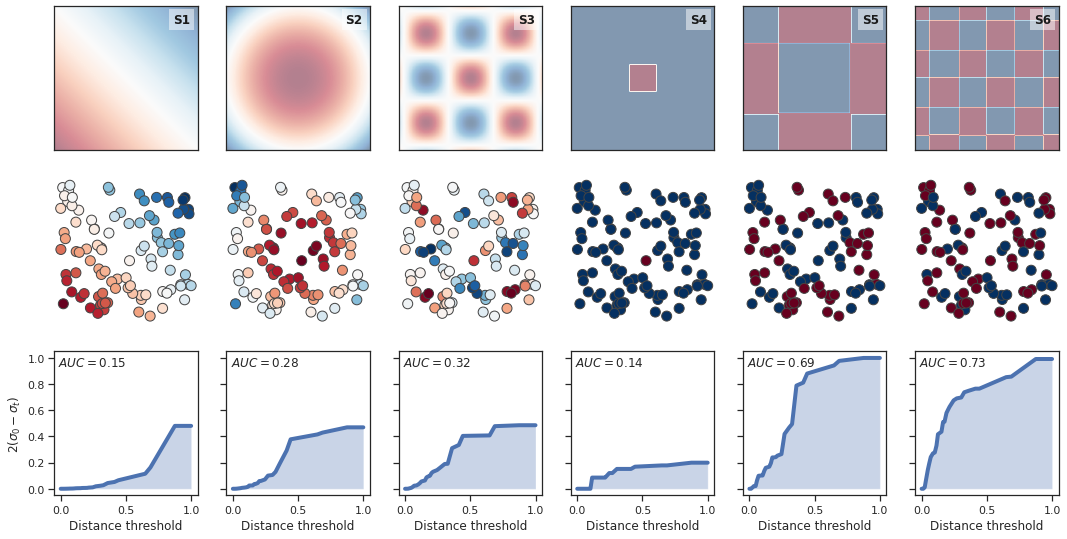

In [22]:
# prepare data grid used for plotting
X0, X1 = np.meshgrid(np.linspace(0, 1, 101), np.linspace(0, 1, 101))

# get random dataset
n = 100
np.random.seed(42)
X = np.random.uniform(size=(n,2))
Dx = distance_matrix(X, X, p=2)

# analytical functions
S1 = SurfaceConstructor('S1')
S2 = SurfaceConstructor('S2')
S3 = SurfaceConstructor('S3')
S4 = SurfaceConstructor('S4')
S5 = SurfaceConstructor('S5')
S6 = SurfaceConstructor('S6')

# dataset of 100 samples
Y1 = S1(X)
Y2 = S2(X)
Y3 = S3(X)
Y4 = S4(X)
Y5 = S5(X)
Y6 = S6(X)

ncols = 6
nrows = 3
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3,nrows*3), sharey='row')

_ = plot_contour(axes[0,0], X0, X1, np.reshape(S1(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S1')
_ = plot_contour(axes[0,1], X0, X1, np.reshape(S2(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S2')
_ = plot_contour(axes[0,2], X0, X1, np.reshape(S3(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S3')
_ = plot_contour(axes[0,3], X0, X1, np.reshape(S4(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S4')
_ = plot_contour(axes[0,4], X0, X1, np.reshape(S5(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1],
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S5')
_ = plot_contour(axes[0,5], X0, X1, np.reshape(S6(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S6')

axes[1,0].scatter(X[:,0], X[:,1], c=Y1.flatten(), cmap='RdBu', s=100, edgecolor='#444444')
axes[1,1].scatter(X[:,0], X[:,1], c=Y2.flatten(), cmap='RdBu', s=100, edgecolor='#444444')
axes[1,2].scatter(X[:,0], X[:,1], c=Y3.flatten(), cmap='RdBu', s=100, edgecolor='#444444')
axes[1,3].scatter(X[:,0], X[:,1], c=Y4.flatten(), cmap='RdBu', s=100, edgecolor='#444444')
axes[1,4].scatter(X[:,0], X[:,1], c=Y5.flatten(), cmap='RdBu', s=100, edgecolor='#444444')
axes[1,5].scatter(X[:,0], X[:,1], c=Y6.flatten(), cmap='RdBu', s=100, edgecolor='#444444')


ri00 = RoughnessIndex(X=X, metric='euclidean', max_dist=np.sqrt(2.), Y=Y1, verbose=False)
ri01 = RoughnessIndex(X=X, metric='euclidean', max_dist=np.sqrt(2.), Y=Y2, verbose=False)
ri02 = RoughnessIndex(X=X, metric='euclidean', max_dist=np.sqrt(2.), Y=Y3, verbose=False)
ri03 = RoughnessIndex(X=X, metric='euclidean', max_dist=np.sqrt(2.), Y=Y4, verbose=False)
ri04 = RoughnessIndex(X=X, metric='euclidean', max_dist=np.sqrt(2.), Y=Y5, verbose=False)
ri05 = RoughnessIndex(X=X, metric='euclidean', max_dist=np.sqrt(2.), Y=Y6, verbose=False)

for i, ri in enumerate([ri00, ri01, ri02, ri03, ri04, ri05]):
    score = ri.compute_index(min_dt=0.01)
    std_loss = ri.property_moments[0] - ri.property_moments
    axes[2,i].plot(ri.distance_thresholds, std_loss, linewidth=4)
    axes[2,i].fill_between(x=ri.distance_thresholds, y1=0.0, y2=std_loss, alpha=0.3)
    axes[2,i].annotate(f'$AUC = {score:.2f}$', xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top')

# labels
for i in range(ncols):
    axes[1,i].axis('off')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[2,0].set_ylabel('$2(\sigma_{0}-\sigma_t)$')
    axes[2,i].set_xlabel('Distance threshold')

fig.savefig('plots/toy-surfaces-and-AUCs.pdf', bbox_inches='tight')

## Method intuition/visualization

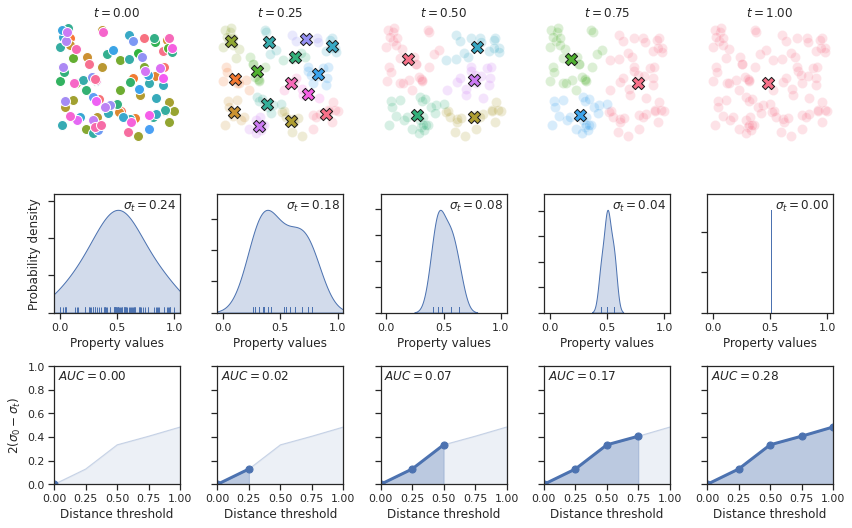

In [24]:
Y = Y3
Y = (Y - Y.min()) / (Y.max() - Y.min())
Dx = distance_matrix(X, X, p=2)
Dx = (Dx - Dx.min()) / (Dx.max() - Dx.min())

ncols = 5
nrows = 3
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*2.4,nrows*2.5), sharex='row', sharey=False)

stddev_0 = np.std(Y, ddof=0)
stddevs = []

for i, d in enumerate([0., 0.25, 0.5, 0.75, 1.0000001]):
    clustering = AgglomerativeClustering(distance_threshold=d, n_clusters=None, affinity="precomputed", linkage='complete')
    clusters = clustering.fit_predict(Dx)

    means = []
    colors = sns.color_palette("husl", len(set(clusters)))
    j = 0
    for cluster in set(clusters):
        mask = clusters == cluster
        
        centroid = np.array([[np.mean(X[mask,0]), np.mean(X[mask,1])]])

        if d < 0.0001:
            axes[0,i].scatter(X[mask,0], X[mask,1], edgecolor='w', s=100, alpha=1., color=colors[j])
        else:
            axes[0,i].scatter(X[mask,0], X[mask,1], edgecolor='w', s=100, alpha=0.2, color=colors[j])
            axes[0,i].scatter(centroid[0,0], centroid[0,1], edgecolor='k', s=150, marker='X', color=colors[j])
        axes[0,i].axis('off')
        
        m = [np.mean(Y[mask])] * sum(mask)
        means.extend(m)
        
        j += 1
    
    sns.kdeplot(means, ax=axes[1,i], shade=True, bw_method=0.7, linewidth=1)
    sns.rugplot(means, ax=axes[1,i], height=0.05)

    stddev = np.std(means, ddof=0)
    stddevs.append(stddev)
    axes[1,i].annotate(f'$\sigma_t = {stddev:.2f}$', xy=(0.97, 0.97), xycoords='axes fraction', ha='right', va='top')

    axes[1,i].set_xlim([-0.05,1.05])
    axes[1,i].set_ylabel('')
    axes[1,i].set_yticklabels([])    
    axes[0,i].set_title(f'$t ={d:.2f}$')

    
    
# Third row with AUC
y = 2 * (stddev_0 - np.array(stddevs))
ds = [0., 0.25, 0.5, 0.75, 1.0]
for i, d in enumerate(ds):
    axes[2,i].plot(ds, y, linewidth=1, alpha=0.3, color='b')
    axes[2,i].fill_between(x=ds, y1=0.0, y2=y, alpha=0.1, color='b')
    
    axes[2,i].plot(ds[:i+1], y[:i+1], linewidth=3, alpha=1, color='b')
    axes[2,i].fill_between(x=ds[:i+1], y1=0.0, y2=y[:i+1], alpha=0.3, color='b')
    axes[2,i].scatter(ds[:i+1], y[:i+1], s=50, marker='o', alpha=1, color='b')
    
    dx = np.diff(ds[:i+1])
    yy = y[:i+1]
    fx = (yy[:-1] + yy[1:]) * 0.5
    auc = np.dot(fx, dx)
    axes[2,i].annotate(f'$AUC = {auc:.2f}$', xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top')

_ = axes[0,0].set_ylabel('Dataset')
_ = axes[1,0].set_ylabel('Probability density')
_ = axes[2,0].set_ylabel('$2(\sigma_0 - \sigma_t)$')


for j in range(5):
    _ = axes[1,j].set_xlabel('Property values')
    _ = axes[2,j].set_xlabel('Distance threshold')
    _ = axes[2,j].set_ylim([0,1])
    _ = axes[2,j].set_xlim([0,1])
    _ = axes[2,j].set_xticks(ds)
    if j > 0:
        _ = axes[2,j].set_ylabel('')
        _ = axes[2,j].set_yticklabels([])    

plt.tight_layout()
fig.savefig('plots/toy_examples-stddev-vs-distance-thresholds.png', dpi=600, bbox_inches='tight')
fig.savefig('plots/toy_examples-stddev-vs-distance-thresholds.pdf', bbox_inches='tight')

### Extreme examples

Clustering...
Clustering...
Clustering...
Clustering...


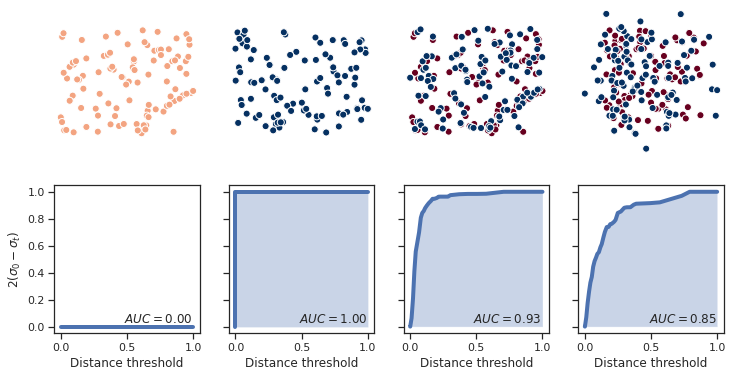

In [25]:
# Smallest index obtained for flat surface
X = np.random.uniform(size=(100, 2))
Y = np.array([0.3] * len(X))
ri0 = RoughnessIndex(Y=Y, X=X, metric='euclidean')
score0 = ri0.compute_index(min_dt=0.01)

# Largest index where we have overlapping points with opposite values
np.random.seed(42)
X_0 = np.random.uniform(size=(100, 2))
Y_0 = [0.]*100
X_1 = X_0
Y_1 = [1.]*100

XX1 = np.concatenate([X_0, X_1])
YY1 = np.concatenate([Y_0, Y_1])
ri1 = RoughnessIndex(Y=YY1, X=XX1, metric='euclidean')
score1 = ri1.compute_index(min_dt=0.01)

# add some distance
X_0 = np.random.uniform(size=(100, 2))
Y_0 = [0.]*100
X_1 = X_0 + np.random.uniform(low=-0.05, high=0.05, size=(100, 2))
Y_1 = [1.]*100

XX2 = np.concatenate([X_0, X_1])
YY2 = np.concatenate([Y_0, Y_1])
ri2 = RoughnessIndex(Y=YY2, X=XX2, metric='euclidean')
score2 = ri2.compute_index(min_dt=0.01)

# add some more distance
X_0 = np.random.uniform(size=(100, 2))
Y_0 = [0.]*100
X_1 = X_0 + np.random.uniform(low=-0.2, high=0.2, size=(100, 2))
Y_1 = [1.]*100

XX3 = np.concatenate([X_0, X_1])
YY3 = np.concatenate([Y_0, Y_1])
ri3 = RoughnessIndex(Y=YY3, X=XX3, metric='euclidean')
score3 = ri3.compute_index(min_dt=0.01)


# -------
# Figure
# -------
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(4*3,2*3), sharey='row')

axes[0,0].scatter(X[:,0], X[:,1], c=Y.flatten(), cmap='RdBu', vmin=0, vmax=1, s=50, edgecolor='w')
axes[0,1].scatter(XX1[:,0], XX1[:,1], c=YY1.flatten(), cmap='RdBu', s=50, edgecolor='w')
axes[0,2].scatter(XX2[:,0], XX2[:,1], c=YY2.flatten(), cmap='RdBu', s=50, edgecolor='w')
axes[0,3].scatter(XX3[:,0], XX3[:,1], c=YY3.flatten(), cmap='RdBu', s=50, edgecolor='w')

std_loss0 = ri0.property_moments[0] - ri0.property_moments
axes[1,0].plot(ri0.distance_thresholds, std_loss0, linewidth=4)
axes[1,0].fill_between(x=ri0.distance_thresholds, y1=0.0, y2=std_loss0, alpha=0.3)
axes[1,0].annotate(f'$AUC = {score0:.2f}$', xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom')

std_loss1 = ri1.property_moments[0] - ri1.property_moments
axes[1,1].plot(ri1.distance_thresholds, std_loss1, linewidth=4)
axes[1,1].fill_between(x=ri1.distance_thresholds, y1=0.0, y2=std_loss1, alpha=0.3)
axes[1,1].annotate(f'$AUC = {score1:.2f}$', xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom')

std_loss2 = ri2.property_moments[0] - ri2.property_moments
axes[1,2].plot(ri2.distance_thresholds, std_loss2, linewidth=4)
axes[1,2].fill_between(x=ri2.distance_thresholds, y1=0.0, y2=std_loss2, alpha=0.3)
axes[1,2].annotate(f'$AUC = {score2:.2f}$', xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom')

std_loss3 = ri3.property_moments[0] - ri3.property_moments
axes[1,3].plot(ri3.distance_thresholds, std_loss3, linewidth=4)
axes[1,3].fill_between(x=ri3.distance_thresholds, y1=0.0, y2=std_loss3, alpha=0.3)
axes[1,3].annotate(f'$AUC = {score3:.2f}$', xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom')

for j in range(4):
    axes[0,j].axis('off')
    axes[1,j].set_xlabel('Distance threshold')
    
axes[1,0].set_ylabel('$2(\sigma_{0}-\sigma_t)$')

fig.savefig('plots/toy_examples-extremes.png', dpi=600, bbox_inches='tight')
fig.savefig('plots/toy_examples-extremes.pdf', bbox_inches='tight')

## Effect of noise

In [26]:
SCORES = {}
SCORES_MEAN = {}
SCORES_STDD = {}
NOISELESS_SCORES = {}

noises = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
n_repeats = 50

# Y0 \in [0,2]
# Y1 \in [0, 0.5]
# Y2 \in [0.29, 1.01]
# Y3 \in [0,1]
# Y4 \in [0,1]
# Y5 \in [0,1]

# use the same points all the time
np.random.seed(42)
X = np.random.uniform(size=(100, 2))

# range of toy functions in [0,1]^2
ybounds = [(0.,2.),(0.,0.5),(0.295,1.708),(0.,1.),(0.,1.),(0.,1.)]

for s, bounds in zip(['S1', 'S2', 'S3', 'S4', 'S5', 'S6'], ybounds):
    print(f'===== {s} =====')
    SCORES[s] = {}
    SCORES_MEAN[s] = []
    SCORES_STDD[s] = []

    constructor = SurfaceConstructor(s)
    Y = np.reshape(constructor(X), newshape=(X.shape[0],1))
    
    # reference, noiseless ROGI
    ri = RoughnessIndex(X=X, metric='euclidean', Y=Y, max_dist=np.sqrt(2.), verbose=False)
    NOISELESS_SCORES[s] = ri.compute_index(min_dt=0.01)
    
    for n in noises:
        print('-->', n, end=' ')
        SCORES[s][n] = []
        
        for _ in range(n_repeats):
            print('.', end='')

            # get Y
            Y = constructor(X)
            
            # add noise
            scale = n * (bounds[1] - bounds[0])
            Y = Y + np.random.normal(loc=0.0, scale=scale, size=len(Y))
            
            ri = RoughnessIndex(X=X, metric='euclidean', 
                                Y=np.reshape(Y, newshape=(X.shape[0],1)), norm_Y=True,
                                max_dist=np.sqrt(2.), verbose=False)
            score = ri.compute_index(min_dt=0.01)
            SCORES[s][n].append(score)
        
        print('')
        
        SCORES_MEAN[s].append(np.mean(SCORES[s][n]))
        SCORES_STDD[s].append(np.std(SCORES[s][n]))

===== S1 =====
--> 0.01 ..................................................
--> 0.05 ..................................................
--> 0.1 ..................................................
--> 0.2 ..................................................
--> 0.3 ..................................................
--> 0.4 ..................................................
--> 0.5 ..................................................
===== S2 =====
--> 0.01 ..................................................
--> 0.05 ..................................................
--> 0.1 ..................................................
--> 0.2 ..................................................
--> 0.3 ..................................................
--> 0.4 ..................................................
--> 0.5 ..................................................
===== S3 =====
--> 0.01 ..................................................
--> 0.05 ..................................................
--> 0

In [27]:
# put results into a dataframe

df = pd.DataFrame(columns=['S1', 'S2', 'S3', 'S4', 'S5', 'S6'])

for s in ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']:
    values = []
    for n in noises:
        values.extend(SCORES[s][n])
    df.loc[:, s] = values

numbers = []
for n in noises:
    numbers.extend([n] * n_repeats)
df.loc[:, 'n'] = numbers

df

,S1,S2,S3,S4,S5,S6,n
0,0.154365,0.280575,0.317967,0.142248,0.667482,0.695823,0.01
1,0.152186,0.290676,0.312680,0.139863,0.662357,0.698844,0.01
2,0.147715,0.284615,0.310380,0.141923,0.667573,0.702162,0.01
3,0.151508,0.285900,0.316106,0.142978,0.663138,0.692219,0.01
4,0.155097,0.280681,0.310315,0.141240,0.666130,0.698058,0.01
...,...,...,...,...,...,...,...
345,0.230260,0.270324,0.332821,0.303362,0.333076,0.318766,0.50
346,0.249956,0.298887,0.307709,0.284505,0.349754,0.265503,0.50
347,0.241440,0.238865,0.324521,0.357869,0.309126,0.311657,0.50
348,0.266385,0.292169,0.262913,0.341056,0.312422,0.342080,0.50


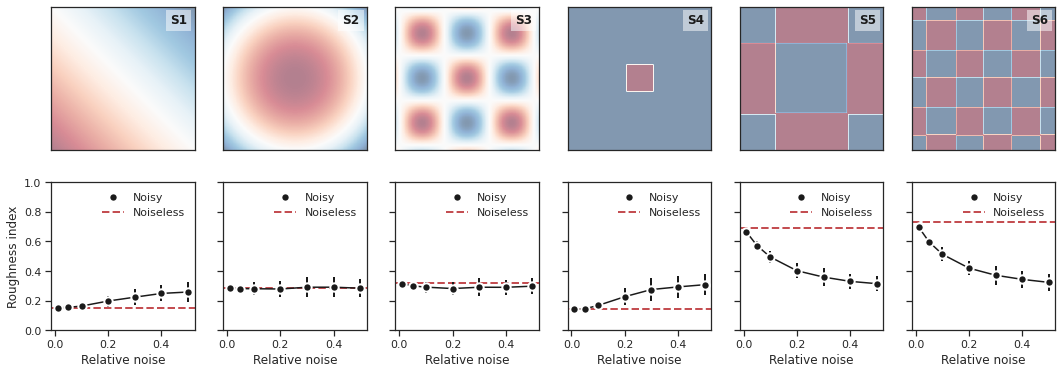

In [30]:
ncols = 6
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3,nrows*3), sharey='row')

_ = plot_contour(axes[0,0], X0, X1, np.reshape(S1(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S1')
_ = plot_contour(axes[0,1], X0, X1, np.reshape(S2(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S2')
_ = plot_contour(axes[0,2], X0, X1, np.reshape(S3(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S3')
_ = plot_contour(axes[0,3], X0, X1, np.reshape(S4(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S4')
_ = plot_contour(axes[0,4], X0, X1, np.reshape(S5(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S5')
_ = plot_contour(axes[0,5], X0, X1, np.reshape(S6(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                 cbar=False, cmap='RdBu', contour_lines=False, annotate='S6')


for i, s in enumerate(['S1', 'S2', 'S3', 'S4', 'S5', 'S6']):
    
    axes[1,i].errorbar(x=noises, y=SCORES_MEAN[s], yerr=np.array(SCORES_STDD[s])*2, elinewidth=2, capsize=0, color='k')
    axes[1,i].scatter(noises, SCORES_MEAN[s], s=70, c='k', zorder=10, edgecolor='w', linewidth=2, label='Noisy')
    
    axes[1,i].axhline(y=NOISELESS_SCORES[s], zorder=0, linestyle='--', color='r', linewidth=2, label='Noiseless')

    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].set_xlabel('Relative noise')
    
    axes[1,i].legend(frameon=False)
    
axes[1,0].set_ylim([0,1])
axes[1,0].set_ylabel('Roughness index')

fig.savefig('plots/toy_examples-noise.png', dpi=600, bbox_inches='tight')

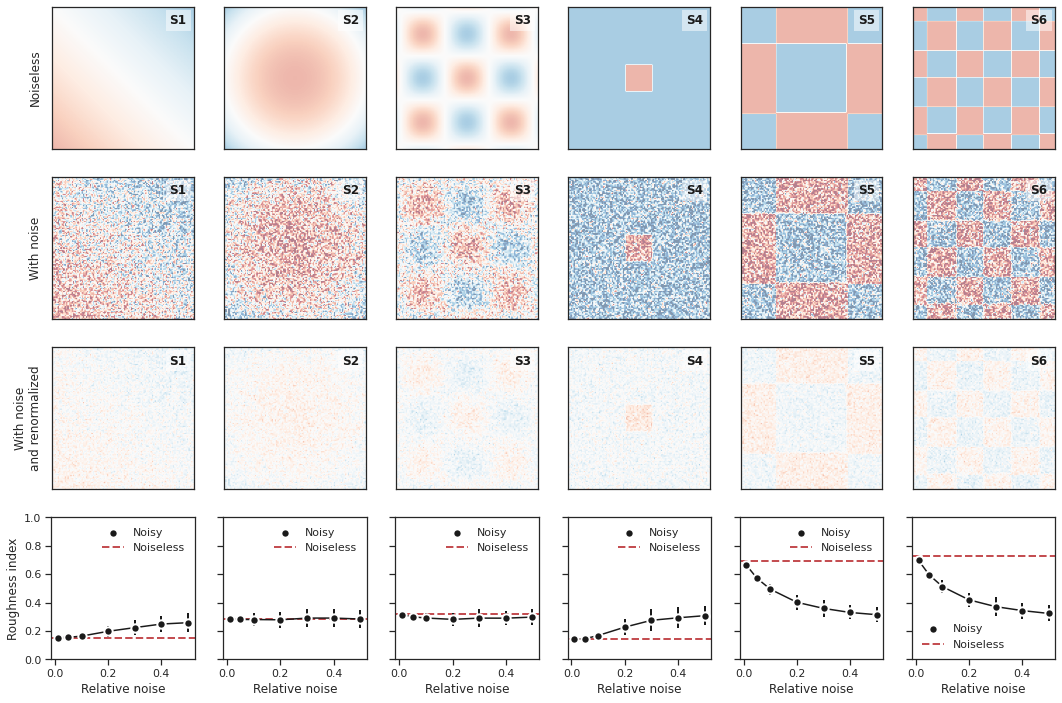

In [33]:
ncols = 6
nrows = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3,nrows*3), sharey='row')

vlims = {'S1': [0.,2.],'S2': [0.,0.5],'S3': [0.295,1.708],'S4': [0.,1.],'S5': [0.,1.],'S6': [0.,1.]}
# extended vlims for visualization (need not to saturate colorbar)
evlims = {'S1': [-0.8, 2.8],'S2': [-0.2,0.7],'S3': [-0.2702, 2.2732],'S4': [-0.4, 1.4],'S5': [-0.4, 1.4],'S6': [-0.4, 1.4]}


# Noiseless surfaces
Y1 = S1(np.array([X0.flatten(),X1.flatten()]).T)
Y2 = S2(np.array([X0.flatten(),X1.flatten()]).T)
Y3 = S3(np.array([X0.flatten(),X1.flatten()]).T)
Y4 = S4(np.array([X0.flatten(),X1.flatten()]).T)
Y5 = S5(np.array([X0.flatten(),X1.flatten()]).T)
Y6 = S6(np.array([X0.flatten(),X1.flatten()]).T)

_ = plot_contour(axes[0,0], X0, X1, np.reshape(Y1, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S1'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S1')
_ = plot_contour(axes[0,1], X0, X1, np.reshape(Y2, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S2'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S2')
_ = plot_contour(axes[0,2], X0, X1, np.reshape(Y3, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S3'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S3')
_ = plot_contour(axes[0,3], X0, X1, np.reshape(Y4, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S4'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S4')
_ = plot_contour(axes[0,4], X0, X1, np.reshape(Y5, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S5'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S5')
_ = plot_contour(axes[0,5], X0, X1, np.reshape(Y6, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S6'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S6')

# Noisy surfaces
n = 0.5
Y1 = Y1 + np.random.normal(loc=0.0, scale=n*2., size=len(Y1))
Y2 = Y2 + np.random.normal(loc=0.0, scale=n*0.5, size=len(Y2))
Y3 = Y3 + np.random.normal(loc=0.0, scale=n*1.708-0.295, size=len(Y3))
Y4 = Y4 + np.random.normal(loc=0.0, scale=n*1., size=len(Y4))
Y5 = Y5 + np.random.normal(loc=0.0, scale=n*1., size=len(Y5))
Y6 = Y6 + np.random.normal(loc=0.0, scale=n*1., size=len(Y6))

_ = plot_contour(axes[1,0], X0, X1, np.reshape(Y1, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S1'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S1')
_ = plot_contour(axes[1,1], X0, X1, np.reshape(Y2, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S2'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S2')
_ = plot_contour(axes[1,2], X0, X1, np.reshape(Y3, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S3'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S3')
_ = plot_contour(axes[1,3], X0, X1, np.reshape(Y4, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S4'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S4')
_ = plot_contour(axes[1,4], X0, X1, np.reshape(Y5, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S5'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S5')
_ = plot_contour(axes[1,5], X0, X1, np.reshape(Y6, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S6'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S6')

# Noisy surfaces with re-normalization
Y1 = (vlims['S1'][1] - vlims['S1'][0]) * (Y1 - Y1.min()) / (Y1.max() - Y1.min()) + vlims['S1'][0]
Y2 = (vlims['S2'][1] - vlims['S2'][0]) * (Y2 - Y2.min()) / (Y2.max() - Y2.min()) + vlims['S2'][0]
Y3 = (vlims['S3'][1] - vlims['S3'][0]) * (Y3 - Y3.min()) / (Y3.max() - Y3.min()) + vlims['S3'][0]
Y4 = (vlims['S4'][1] - vlims['S4'][0]) * (Y4 - Y4.min()) / (Y4.max() - Y4.min()) + vlims['S4'][0]
Y5 = (vlims['S5'][1] - vlims['S5'][0]) * (Y5 - Y5.min()) / (Y5.max() - Y5.min()) + vlims['S5'][0]
Y6 = (vlims['S6'][1] - vlims['S6'][0]) * (Y6 - Y6.min()) / (Y6.max() - Y6.min()) + vlims['S6'][0]

_ = plot_contour(axes[2,0], X0, X1, np.reshape(Y1, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S1'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S1')
_ = plot_contour(axes[2,1], X0, X1, np.reshape(Y2, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S2'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S2')
_ = plot_contour(axes[2,2], X0, X1, np.reshape(Y3, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S3'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S3')
_ = plot_contour(axes[2,3], X0, X1, np.reshape(Y4, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S4'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S4')
_ = plot_contour(axes[2,4], X0, X1, np.reshape(Y5, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S5'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S5')
_ = plot_contour(axes[2,5], X0, X1, np.reshape(Y6, newshape=X0.shape), [0,1], [0,1], vlims=evlims['S6'], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S6')

# scatter plots
for i, s in enumerate(['S1', 'S2', 'S3', 'S4', 'S5', 'S6']):
    
    axes[-1,i].errorbar(x=noises, y=SCORES_MEAN[s], yerr=np.array(SCORES_STDD[s])*2, elinewidth=2, capsize=0, color='k')
    axes[-1,i].scatter(noises, SCORES_MEAN[s], s=70, c='k', zorder=10, edgecolor='w', linewidth=2, label='Noisy')
    axes[-1,i].axhline(y=NOISELESS_SCORES[s], zorder=0, linestyle='--', color='r', linewidth=2, label='Noiseless')
    axes[-1,i].set_xlabel('Relative noise')
    axes[-1,i].legend(frameon=False)
    
    # rm ticks
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[2,i].set_xticks([])
    axes[2,i].set_yticks([])
    
axes[-1,0].set_ylim([0,1])

axes[0,0].set_ylabel('Noiseless')
axes[1,0].set_ylabel('With noise')
axes[2,0].set_ylabel('With noise\nand renormalized')
axes[3,0].set_ylabel('Roughness index')

fig.savefig('plots/toy_examples-noise-multirow.pdf', bbox_inches='tight')
fig.savefig('plots/toy_examples-noise-multirow.png', dpi=600, bbox_inches='tight')

## Convergence of the roughness index

In [34]:
SCORES = {}
SCORES_MEAN = {}
SCORES_STDD = {}

all_n = [10, 50, 100, 250, 500, 1000]
n_repeats = 50

for s in ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']:
    print(f'===== {s} =====')
    SCORES[s] = {}
    SCORES_MEAN[s] = []
    SCORES_STDD[s] = []

    constructor = SurfaceConstructor(s)
    
    for n in all_n:
        print('-->', n, end=' ')
        SCORES[s][n] = []
        
        for _ in range(n_repeats):
            print('.', end='')

            X = np.random.uniform(low=0., high=1., size=(n,2))
            Y = np.reshape(constructor(X), newshape=(X.shape[0],1))
            ri = RoughnessIndex(X=X, metric='euclidean', Y=Y, max_dist=np.sqrt(2.), verbose=False)
            score = ri.compute_index(min_dt=0.01)
            SCORES[s][n].append(score)
        
        print('')
        
        SCORES_MEAN[s].append(np.mean(SCORES[s][n]))
        SCORES_STDD[s].append(np.std(SCORES[s][n]))

===== S1 =====
--> 10 ..................................................
--> 50 ..................................................
--> 100 ..................................................
--> 250 ..................................................
--> 500 ..................................................
--> 1000 ..................................................
===== S2 =====
--> 10 ..................................................
--> 50 ..................................................
--> 100 ..................................................
--> 250 ..................................................
--> 500 ..................................................
--> 1000 ..................................................
===== S3 =====
--> 10 ..................................................
--> 50 ..................................................
--> 100 ..................................................
--> 250 ..................................................
--> 500 .......

In [35]:
df = pd.DataFrame(columns=['S1', 'S2', 'S3', 'S4', 'S5', 'S6'])

for s in ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']:
    values = []
    for n in all_n:
        values.extend(SCORES[s][n])
    df.loc[:, s] = values

numbers = []
for n in all_n:
    numbers.extend([n] * n_repeats)
df.loc[:, 'n'] = numbers

df

,S1,S2,S3,S4,S5,S6,n
0,0.278907,0.390002,0.375276,0.000000,0.692702,0.625260,10
1,0.266595,0.419851,0.398713,0.000000,0.507088,0.624135,10
2,0.435746,0.342627,0.506960,0.371589,0.549095,0.680869,10
3,0.250803,0.324230,0.447551,0.361796,0.652386,0.836285,10
4,0.274190,0.442737,0.396074,0.000000,0.640163,0.558926,10
...,...,...,...,...,...,...,...
295,0.092359,0.233161,0.301802,0.208202,0.613639,0.801438,1000
296,0.106682,0.210789,0.313477,0.271282,0.612471,0.779841,1000
297,0.088910,0.234214,0.288930,0.230185,0.602350,0.796313,1000
298,0.101371,0.249173,0.278788,0.274139,0.682461,0.778549,1000


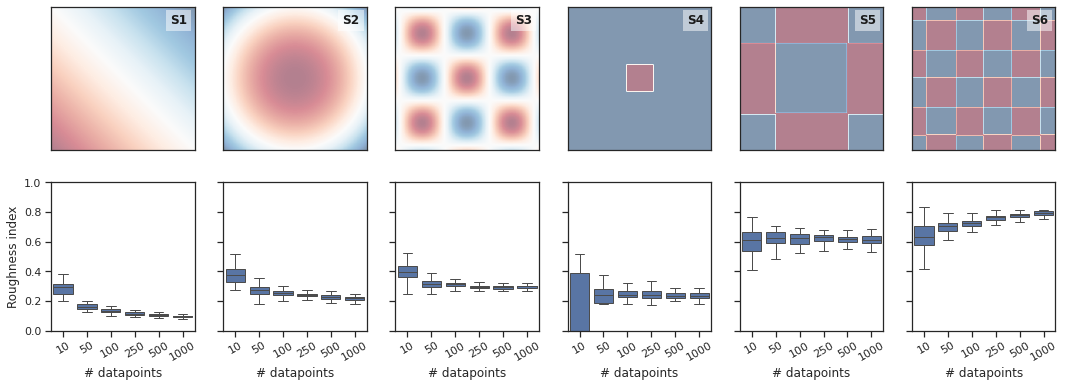

In [38]:
ncols = 6
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3,nrows*3), sharey='row')

_ = plot_contour(axes[0,0], X0, X1, np.reshape(S1(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S1')
_ = plot_contour(axes[0,1], X0, X1, np.reshape(S2(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S2')
_ = plot_contour(axes[0,2], X0, X1, np.reshape(S3(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S3')
_ = plot_contour(axes[0,3], X0, X1, np.reshape(S4(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S4')
_ = plot_contour(axes[0,4], X0, X1, np.reshape(S5(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S5')
_ = plot_contour(axes[0,5], X0, X1, np.reshape(S6(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S6')

for i, s in enumerate(['S1', 'S2', 'S3', 'S4', 'S5', 'S6']):
    
    sns.boxplot(data=df.loc[:, [s,'n']], x="n", y=s, ax=axes[1,i], color='b', linewidth=1., showfliers=False)

    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].set_xlabel('# datapoints')
    axes[1,i].set_ylabel('')
    _ = axes[1,i].set_xticklabels(all_n, rotation=30)
    
axes[1,0].set_ylim([0,1])
axes[1,0].set_ylabel('Roughness index')

fig.savefig('plots/toy_examples-index-convergence-boxplot.png', dpi=600, bbox_inches='tight')
fig.savefig('plots/toy_examples-index-convergence-boxplot.pdf', bbox_inches='tight')

## RF cross-validation error

In [39]:
def get_rmse_given_n(n, y_constructor, model=RandomForestRegressor(n_estimators=100)):
    
    X = np.random.uniform(low=0., high=1., size=(n,2))
    Y = y_constructor(X)
    
    if Y.max() - Y.min() < 1e-8:
        Y_norm = Y - Y.min()
    else:
        Y_norm = (Y - Y.min()) / (Y.max() - Y.min())
        
    cv_results = cross_validate(model, X, Y_norm, cv=10, scoring=('neg_mean_squared_error'))
    rmses = np.sqrt(-cv_results['test_score'])
    return np.mean(rmses)


all_n = [10, 50, 100, 250, 500, 1000]
RMSE_MEAN = {}
RMSE_STDD = {}
RMSES = {}
n_repeats = 50

for s in ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']:
    print(f'==== {s} ====')
    
    RMSE_MEAN[s] = []
    RMSE_STDD[s] = []
    RMSES[s] = {}

    constructor = SurfaceConstructor(s)
    
    for n in all_n:
        print('-->', n, end=' ')
        
        RMSES[s][n] = []
        for _ in range(n_repeats):
            print('.', end='')
            model = RandomForestRegressor(n_estimators=50, n_jobs=12, random_state=42)
            rmse = get_rmse_given_n(n=n, y_constructor=constructor, model=model)
            RMSES[s][n].append(rmse)
        
        print('')
        RMSE_MEAN[s].append(np.mean(RMSES[s][n]))
        RMSE_STDD[s].append(np.std(RMSES[s][n]))

==== S1 ====
--> 10 ..................................................
--> 50 ..................................................
--> 100 ..................................................
--> 250 ..................................................
--> 500 ..................................................
--> 1000 ..................................................
==== S2 ====
--> 10 ..................................................
--> 50 ..................................................
--> 100 ..................................................
--> 250 ..................................................
--> 500 ..................................................
--> 1000 ..................................................
==== S3 ====
--> 10 ..................................................
--> 50 ..................................................
--> 100 ..................................................
--> 250 ..................................................
--> 500 .............

Text(0, 0.5, 'CV RMSE')

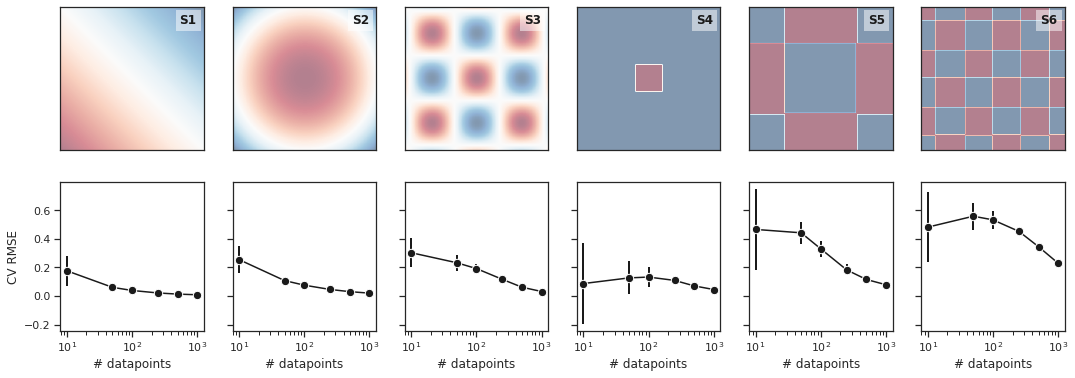

In [40]:
ncols = 6
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3,nrows*3), sharey='row')

_ = plot_contour(axes[0,0], X0, X1, np.reshape(S1(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S1')
_ = plot_contour(axes[0,1], X0, X1, np.reshape(S2(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S2')
_ = plot_contour(axes[0,2], X0, X1, np.reshape(S3(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S3')
_ = plot_contour(axes[0,3], X0, X1, np.reshape(S4(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S4')
_ = plot_contour(axes[0,4], X0, X1, np.reshape(S5(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S5')
_ = plot_contour(axes[0,5], X0, X1, np.reshape(S6(np.array([X0.flatten(),X1.flatten()]).T), newshape=X0.shape), [0,1], [0,1], 
                cbar=False, cmap='RdBu', contour_lines=False, annotate='S6')

for i, s in enumerate(['S1', 'S2', 'S3', 'S4', 'S5', 'S6']):
    
    axes[1,i].errorbar(x=all_n, y=RMSE_MEAN[s], yerr=np.array(RMSE_STDD[s])*2, elinewidth=2, capsize=0, color='k')
    axes[1,i].scatter(all_n, RMSE_MEAN[s], s=70, c='k', zorder=10, edgecolor='w')
    
    axes[1,i].set_xlabel('# datapoints')
    axes[1,i].set_xscale('log')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

axes[1,0].set_ylabel('CV RMSE')

### Plot RMSE vs Roughness

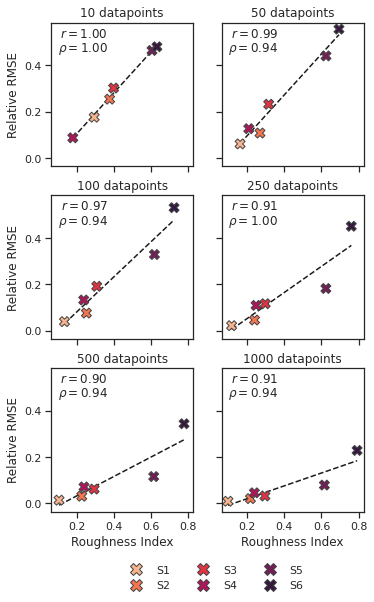

In [42]:
ncols = 2
nrows = 3
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*2.8,nrows*3), sharex=True, sharey=True)

def plotcorr(ax, x, y, title, color='b', alpha=1, label='', fit=False, annotate=True):
    
    if fit:
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d( coef) 
        ax.plot([min(x), max(x)], [poly1d_fn(min(x)), poly1d_fn(max(x))], '--k', zorder=0)

    ax.scatter(x, y, marker='X', s=100, color=color, label=label, edgecolor='#444444', alpha=alpha)
    pears = pearsonr(x, y)[0]
    spear = spearmanr(x, y)[0]
    _ = ax.set_title(title)
    
    if annotate is True:
        _ = ax.annotate(f'$r = {pears:.2f}$', xy=(0.4, 0.9), xycoords='axes fraction', ha='right')
        _ = ax.annotate(f'$\\rho = {spear:.2f}$', xy=(0.4, 0.8), xycoords='axes fraction', ha='right')
    

colors = sns.color_palette("rocket_r", 6)
for i,n in enumerate(all_n):
    row = i // ncols
    col = i % ncols
    rmse = [RMSE_MEAN[key][i] for key in RMSE_MEAN.keys()]
    score = [SCORES_MEAN[key][i] for key in RMSE_MEAN.keys()]
    plotcorr(axes[row,col], np.array(score), rmse, f'{n} datapoints', color=colors, fit=True)

for i in range(nrows):
    axes[i,0].set_ylabel('Relative RMSE')
axes[2,0].set_xlabel('Roughness Index')
axes[2,1].set_xlabel('Roughness Index')

# legend
from matplotlib.lines import Line2D
ms = 12
legend_elements = [Line2D([0], [0], marker='X', linestyle='None', color='#444444', label='S1', markerfacecolor=colors[0], markersize=ms),
                    Line2D([0], [0], marker='X', linestyle='None', color='#444444', label='S2', markerfacecolor=colors[1], markersize=ms),
                    Line2D([0], [0], marker='X', linestyle='None', color='#444444', label='S3', markerfacecolor=colors[2], markersize=ms),
                    Line2D([0], [0], marker='X', linestyle='None', color='#444444', label='S4', markerfacecolor=colors[3], markersize=ms),
                    Line2D([0], [0], marker='X', linestyle='None', color='#444444', label='S5', markerfacecolor=colors[4], markersize=ms),
                    Line2D([0], [0], marker='X', linestyle='None', color='#444444', label='S6', markerfacecolor=colors[5], markersize=ms)]

axes[2,0].legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(1.15, -0.3), frameon=False)

fig.savefig('plots/toy_examples-rogi_vs_rmse.png', dpi=600, bbox_inches='tight')
fig.savefig('plots/toy_examples-rogi_vs_rmse.pdf', bbox_inches='tight')